In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install holidays
import holidays
from scipy.stats import skew
from scipy.stats import kurtosis

#from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 

# from sklearn import necessary packages for naive bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# Define file pathname
base = "Bike share ridership/Bike share ridership "
extension = [
    "2023-01", "2023-02", "2023-03", "2023-04", "2023-05", "2023-06",
    "2023-07", "2023-08", "2023-09", "2023-10", "2023-11", "2023-12",
    ]

# Define columns order in a list
columns = [
    "Trip Id", "Trip Duration", "Start Station Id", "Start Time",
    "Start Station Name", "End Station Id", "End Time",
    "End Station Name", "Bike Id", "User Type"
    ]

# Used to store file paths
paths = []

# Loop through file extensions and combine them to locate them individually
for month in extension:
    path = base + month + ".csv"
    paths.append(path)

# Used to store the individual data frames
all_dfs = []

# Clean columns (Inconsistencies between 2024 and other years)
# Mismatch beteen the years issued a lot of NaN values. Trip Id was duplicated (2024 had its own).
for file in paths:
    df_temp = pd.read_csv(file, encoding = "latin1")
    df_temp.columns = [col.replace("ï»¿", "").strip() for col in df_temp.columns]

    # Used to clean BOM character for "Trip Id" (2024)
    if "ï»¿Trip Id" in df_temp.columns:
        df_temp["Trip Id"] = df_temp["ï»¿Trip Id"]
        df_temp = df_temp.drop(columns = ["ï»¿Trip Id"])

    #remove extra space in Trip Duration column
    #df.columns = df.columns.str.replace("Trip  Duration", "Trip Duration")
    df_temp.rename(columns={"Trip  Duration": "Trip Duration"}, inplace=True)

    # Reindexes the data frame according to columns list.
    df_temp = df_temp.reindex(columns = columns)
    all_dfs.append(df_temp)

# Concatinate dataframe
df = pd.concat(all_dfs, ignore_index = True)

# Drop "Model" to stay consistent with previous years (Only present in 2024)
df = df.drop(columns = ["Model", "Bike Id"], errors = "ignore")


df = df.set_index("Trip Id")

# NEXT STEPS: Look into Start Station Name and End Station Name.


In [8]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type']

In [9]:
print(f"Start Station Name: {df['Start Station Name'].nunique()}")
print(f"End Station Name: {df['End Station Name'].nunique()}")

Start Station Name: 593
End Station Name: 592


In [10]:
df.isna().sum()

Trip Duration              0
Start Station Id           0
Start Time                 0
Start Station Name    595075
End Station Id          2944
End Time                   0
End Station Name      598563
User Type                  0
dtype: int64

In [4]:
### START TIME
#split start time into 2 columns
df[['Start Date', 'Start Time']] = df['Start Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('Start Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['Start Date'] = pd.to_datetime(df['Start Date'], format = '%m/%d/%Y')

In [5]:
### END TIME
#split start time into 2 columns
df[['End Date', 'End Time']] = df['End Time'].str.split(' ', expand=True)

#move start date to the 3rd index
col = df.pop('End Date')
df.insert(3, col.name, col)

#convert date to datetime format
df['End Date'] = pd.to_datetime(df['End Date'], format = '%m/%d/%Y')

In [7]:
### START TIME
#split date into day/month but keep og column
df['Start Day'] = df['Start Date'].dt.day

df['Start Month'] = df['Start Date'].dt.month

#move start day to the 4th index
col = df.pop('Start Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('Start Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [8]:
### END TIME
#split date into day/month but keep og column
df['End Day'] = df['End Date'].dt.day

df['End Month'] = df['End Date'].dt.month

#move start day to the 4th index
col = df.pop('End Day')
df.insert(4, col.name, col)

#move start month to the 5th index
col = df.pop('End Month')
df.insert(5, col.name, col)


#change trip duration to minutes/hours
def convert(seconds):
    seconds = seconds % (24 * 60 * 60)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60

    return "%d:%02d:%02d" % (hour, minutes, seconds)


#df['Trip Duration'] = df['Trip Duration'].apply(convert)
df.tail()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type
Trip Id,,,,,,,,,,,,,,
26682732,185,7391,23:56,2023-12-31,31,12,31,12,2023-12-31,Yonge St / Dundas Sq,7041.0,23:59,Edward St / Yonge St,Casual Member
26682733,802,7366,23:56,2024-01-01,1,1,31,12,2023-12-31,Fort York Blvd / Bathurst St SMART,7048.0,00:10,Front St W / Yonge St (Hockey Hall of Fame),Casual Member
26682735,1314,7203,23:57,2024-01-01,1,1,31,12,2023-12-31,Bathurst St/Queens Quay(Billy Bishop Airport),7719.0,00:19,NaN,Casual Member
26682737,371,7788,23:58,2024-01-01,1,1,31,12,2023-12-31,NaN,7788.0,00:05,NaN,Casual Member
26682738,1271,7298,23:59,2024-01-01,1,1,31,12,2023-12-31,Bathurst St / Adelaide St W,7075.0,00:21,Queens Quay W / Dan Leckie Way,Casual Member


In [9]:
#create weekday/weekend column
df['Weekday/Weekend'] = df['Start Date'].dt.weekday.apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

df.head()

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
20148784,840,7022,00:00,2023-01-01,1,1,1,1,2023-01-01,Simcoe St / Queen St W,7703.0,00:14,NaN,Casual Member,Weekend
20148785,722,7399,00:01,2023-01-01,1,1,1,1,2023-01-01,Lower Jarvis / Queens Quay E,7533.0,00:13,Housey St / Dan Leckie Way,Casual Member,Weekend
20148786,1054,7269,00:02,2023-01-01,1,1,1,1,2023-01-01,Toronto Eaton Centre (Yonge St),7076.0,00:20,York St / Queens Quay W,Annual Member,Weekend
20148790,1329,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend
20148791,1291,7721,00:04,2023-01-01,1,1,1,1,2023-01-01,NaN,7685.0,00:26,NaN,Casual Member,Weekend


In [10]:
# Checking if the Weekday/Weekend column is correct in July
df[(df['Weekday/Weekend'] == 'Weekend') & (df['Start Date'].dt.year == 2023) & (df['Start Date'].dt.month == 7)].sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend
Trip Id,,,,,,,,,,,,,,,
22891118,842,7101,18:13,2023-07-08,8,7,8,7,2023-07-08,Lower Sherbourne St / The Esplanade,7102.0,18:27,Nelson St / Duncan St,Casual Member,Weekend
22694621,1834,7025,07:48,2023-07-01,1,7,1,7,2023-07-01,Ted Rogers Way / Bloor St E,7427.0,08:18,Northern Dancer Blvd / Lake Shore Blvd E,Casual Member,Weekend
23080726,242,7654,18:23,2023-07-15,15,7,15,7,2023-07-15,Bloor St W / Pacific Ave,7466.0,18:27,Glendonwynne Ave / Bloor St W,Casual Member,Weekend
22887128,1202,7291,16:00,2023-07-08,8,7,8,7,2023-07-08,190 Queens Quay E,7366.0,16:20,Fort York Blvd / Bathurst St SMART,Casual Member,Weekend
23077365,260,7720,16:25,2023-07-15,15,7,15,7,2023-07-15,NaN,7000.0,16:29,Fort York Blvd / Capreol Ct,Casual Member,Weekend
23080812,1741,7175,18:26,2023-07-15,15,7,15,7,2023-07-15,HTO Park (Queens Quay W),7416.0,18:55,Spadina Ave / Blue Jays Way,Casual Member,Weekend
23308091,637,7536,22:16,2023-07-23,23,7,23,7,2023-07-23,Palmerston Ave / Dundas St W,7542.0,22:27,Queen St W / John St,Casual Member,Weekend
23108151,1159,7240,19:53,2023-07-16,16,7,16,7,2023-07-16,Bloor St W / Shaw Ave - SMART,7298.0,20:12,Bathurst St / Adelaide St W,Casual Member,Weekend
23295692,923,7189,13:18,2023-07-23,23,7,23,7,2023-07-23,Augusta Ave / Denison Sq,7172.0,13:34,Strachan Ave / Princes' Blvd,Casual Member,Weekend


In [11]:
# Added a new column Trip Duration (mm:ss)
df['Trip Duration (mm:ss)'] = df['Trip Duration'].apply(lambda x: f"{x // 60}:{x % 60:02d}")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss)
Trip Id,,,,,,,,,,,,,,,,
22084369,1777,7517,18:31,2023-06-06,6,6,6,6,2023-06-06,Ripley Ave / Ormskirk Ave,7322.0,19:01,King St W / Brant St,Casual Member,Weekday,29:37
21329770,779,7537,12:09,2023-05-06,6,5,6,5,2023-05-06,Euclid Ave / Herrick St - SMART,7072.0,12:22,Fleet St / Bathurst St,Casual Member,Weekend,12:59
25372993,1867,7222,20:03,2023-10-04,4,10,4,10,2023-10-04,Sunnyside - Gus Ryder Pool,7467.0,20:34,Lower Simcoe St / Bremner Blvd,Casual Member,Weekday,31:07
20530924,867,7028,16:40,2023-02-23,23,2,23,2,2023-02-23,Gould St / Mutual St,7575.0,16:55,Bayview Ave / Lawren Harris Square,Casual Member,Weekday,14:27
23899954,155,7040,04:45,2023-08-14,14,8,14,8,2023-08-14,Euclid Ave / Bloor St W,7061.0,04:47,Dalton Rd / Bloor St W,Casual Member,Weekday,2:35
25931108,301,7038,22:54,2023-10-30,30,10,30,10,2023-10-30,Dundas St W / Yonge St,7121.0,22:59,Jarvis St / Dundas St E,Casual Member,Weekday,5:01
21668485,2046,7220,17:39,2023-05-21,21,5,21,5,2023-05-21,Lake Shore Blvd W / Ellis Ave,7514.0,18:13,Humber Bay Shores Park / Marine Parade Dr,Casual Member,Weekend,34:06
20928976,385,7533,06:11,2023-04-11,11,4,11,4,2023-04-11,Housey St / Dan Leckie Way,7216.0,06:18,Wellington St W / Stafford St,Annual Member,Weekday,6:25
21476301,1483,7272,22:39,2023-05-12,12,5,12,5,2023-05-12,Yonge St / Dundonald St - SMART,7682.0,23:04,NaN,Casual Member,Weekday,24:43


In [12]:
# Lists that determine what we defined as peak hours
peak_morning = [6, 7, 8, 9]
peak_evening = [15, 16, 17, 18, 19]

# Assign hour the 'Start Time' hour
hours = pd.to_datetime(df['Start Time'], format='%H:%M').dt.hour

# Defined list for a cleaner code 
conditions = [hours.isin(peak_morning), hours.isin(peak_evening)]
choices = ["Morning", "Evening"]

df['Peak Hour'] = np.select(conditions, choices, default = "Off Peak")

df.sample(10)

,Trip Duration,Start Station Id,Start Time,End Date,End Day,End Month,Start Day,Start Month,Start Date,Start Station Name,End Station Id,End Time,End Station Name,User Type,Weekday/Weekend,Trip Duration (mm:ss),Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
25001995,680,7053,18:48,2023-09-21,21,9,21,9,2023-09-21,Metro Hall Plaza,7164.0,18:59,Gould St / Yonge St (Ryerson University),Casual Member,Weekday,11:20,Evening
22256623,516,7346,16:48,2023-06-14,14,6,14,6,2023-06-14,Logan Av / Gerrard St E,7343.0,16:56,Alton Ave / Dundas St E (Greenwood Park),Casual Member,Weekday,8:36,Evening
25939790,514,7288,13:56,2023-10-31,31,10,31,10,2023-10-31,Humber Bay Shores Park West,7225.0,14:04,Lake Shore Blvd W / Windermere Ave,Casual Member,Weekday,8:34,Off Peak
24168357,181,7475,17:45,2023-08-23,23,8,23,8,2023-08-23,Jarvis St / Richmond St E,7458.0,17:48,Church St / Lombard St,Casual Member,Weekday,3:01,Evening
24805758,304,7324,08:38,2023-09-15,15,9,15,9,2023-09-15,King St W / Charlotte St (West Side),7015.0,08:43,King St W / Bay St (West Side),Casual Member,Weekday,5:04,Morning
21599258,425,7030,08:44,2023-05-18,18,5,18,5,2023-05-18,Bay St / Wellesley St W,7021.0,08:51,Bay St / Albert St,Casual Member,Weekday,7:05,Morning
25267291,1252,7089,09:57,2023-10-01,1,10,1,10,2023-10-01,Church St / Wood St,7596.0,10:18,Langford Ave / Danforth Ave - SMART,Casual Member,Weekend,20:52,Morning
22447350,450,7112,16:54,2023-06-21,21,6,21,6,2023-06-21,Liberty St / Fraser Ave Green P,7227.0,17:02,Martin Goodman Trail (Marilyn Bell Park),Casual Member,Weekday,7:30,Evening
21618012,563,7195,04:08,2023-05-19,19,5,19,5,2023-05-19,Ulster St / Bathurst St,7035.0,04:18,Queen St W / Ossington Ave,Casual Member,Weekday,9:23,Off Peak


In [19]:
df.columns.tolist()

['Trip Duration',
 'Start Station Id',
 'Start Time',
 'End Date',
 'End Day',
 'End Month',
 'Start Day',
 'Start Month',
 'Start Date',
 'Start Station Name',
 'End Station Id',
 'End Time',
 'End Station Name',
 'User Type',
 'Weekday/Weekend',
 'Trip Duration (mm:ss)',
 'Peak Hour']

In [13]:
order = ['Trip Duration', 'Trip Duration (mm:ss)', 
         'Start Station Id', 'Start Station Name', 'Start Time', 'Start Day', 'Start Month', 'Start Date', 
         'End Station Id', 'End Station Name', 'End Time', 'End Day', 'End Month', 'End Date',
         'User Type', 'Weekday/Weekend', 'Peak Hour']

df = df[order]
#df = df.drop(columns = ["Trip Duration"], errors = "ignore")
df.sample(10)

,Trip Duration,Trip Duration (mm:ss),Start Station Id,Start Station Name,Start Time,Start Day,Start Month,Start Date,End Station Id,End Station Name,End Time,End Day,End Month,End Date,User Type,Weekday/Weekend,Peak Hour
Trip Id,,,,,,,,,,,,,,,,,
21999992,950,15:50,7662,Beaty Ave / Queen St W,15:42,3,6,2023-06-03,7205.0,Rusholme Park Cres / College St,15:57,3,6,2023-06-03,Casual Member,Weekend,Evening
20933888,409,6:49,7164,Gould St / Yonge St (Ryerson University),12:45,11,4,2023-04-11,7248.0,Baldwin Ave / Spadina Ave - SMART,12:52,11,4,2023-04-11,Annual Member,Weekday,Off Peak
23834410,2153,35:53,7403,Lascelles Blvd / Eglinton Ave W,18:15,11,8,2023-08-11,7161.0,Beverley St / College St,18:51,11,8,2023-08-11,Casual Member,Weekday,Evening
25458612,864,14:24,7058,Huron/ Harbord St,18:16,8,10,2023-10-08,7416.0,Spadina Ave / Blue Jays Way,18:31,8,10,2023-10-08,Casual Member,Weekend,Evening
23096957,3029,50:29,7662,Beaty Ave / Queen St W,14:43,16,7,2023-07-16,7662.0,Beaty Ave / Queen St W,15:34,16,7,2023-07-16,Casual Member,Weekend,Off Peak
26569430,288,4:48,7691,NaN,18:39,15,12,2023-12-15,7239.0,Bloor St W / Manning Ave - SMART,18:44,15,12,2023-12-15,Casual Member,Weekday,Evening
23832728,139,2:19,7497,128 Sterling Ave - SMART,17:42,11,8,2023-08-11,7182.0,Sterling Rd / Dundas St W,17:45,11,8,2023-08-11,Casual Member,Weekday,Evening
21090725,1613,26:53,7075,Queens Quay W / Dan Leckie Way,17:40,19,4,2023-04-19,7667.0,Spadina Ave / Sussex Ave - SMART,18:07,19,4,2023-04-19,Casual Member,Weekday,Evening
24967797,1434,23:54,7034,Church St / Bloor St E,17:32,20,9,2023-09-20,7032.0,Augusta Ave / Dundas St W,17:55,20,9,2023-09-20,Casual Member,Weekday,Evening


In [14]:
# reset numeric variable to categorical
df['Start Station Id']=df['Start Station Id'].astype('category')
df['End Station Id']=df['End Station Id'].astype('category')
df['Start Day']=df['Start Day'].astype('category')
df['End Day']=df['End Day'].astype('category')
df['Start Month']=df['Start Month'].astype('category')
df['End Month']=df['End Month'].astype('category')

In [22]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

#Trip_summary = summary_stats(df, 'Trip Duration (mm:ss)')

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': np.float64(17.98991376780887), 'median': np.float64(11.45), 'mode': [7.2], 'std_dev': np.float64(146.63290742720739)}


In [15]:
# function to find outliers using z-score
def find_outliers_zscore(column, threshold=3):
    # remove na values
    series = column.dropna()
    
    mean = series.mean()/60
    std = series.std()/60
    
    z_scores = (series/60 - mean) / std

        # boolean mask
    mask = np.abs(z_scores) > threshold

    # return list of outlier values
    return series[mask].tolist()



outliers = find_outliers_zscore(df["Trip Duration"])

# proportion of outliers
num_outliers = df['Trip Duration'].isin(outliers).sum()
proportion_outliers = num_outliers / len(df)

print(proportion_outliers)


0.0009920987421805274


In [16]:
# remove outliers

# replace outliers with NaN
df['Trip Duration'] = df['Trip Duration'].mask(df['Trip Duration'].isin(outliers), np.nan)

# drop rows where Trip Duration is NaN
df = df.dropna(subset=['Trip Duration']).reset_index(drop=True)

In [25]:
# calculate summary statistics

def summary_stats(column):
    # remove na values
    series = column.dropna()

    return {
        "mean": series.mean()/ 60,
        "median": series.median() /60,
        "mode": (series.mode()/60).tolist(),  # Could be multiple modes
        "std_dev": series.std()/ 60
    }

trip_summary = summary_stats(df['Trip Duration'])

print(trip_summary)


{'mean': np.float64(15.847835565757384), 'median': np.float64(11.45), 'mode': [7.2], 'std_dev': np.float64(18.41774166455083)}


In [26]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Peak Hour')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

Peak Hour         
Evening    mean                   16.632388
           median                     12.05
           mode                       [7.8]
           std_dev                18.421291
Morning    mean                   12.770837
           median                      10.3
           mode       [0.03333333333333333]
           std_dev                 13.49441
Off Peak   mean                   16.177246
           median                 11.366667
           mode                       [7.2]
           std_dev                19.738693
Name: Trip Duration, dtype: object


In [27]:
# group by 'peak/offpeak' and apply summary_stats
trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)

print(trip_summary_by_peak)

/var/folders/bf/s3j1jf9135v9ymnydc79kyjw0000gn/T/ipykernel_8569/1759528924.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_summary_by_peak = df.groupby('Start Month')['Trip Duration'].apply(summary_stats)


Start Month         
1            mean                    12.79995
             median                       9.9
             mode       [0.03333333333333333]
             std_dev                13.129628
2            mean                   13.449612
             median                 10.416667
             mode         [7.466666666666667]
             std_dev                13.672272
3            mean                   13.233047
             median                      10.3
             mode         [5.816666666666666]
             std_dev                13.008713
4            mean                    15.65183
             median                      11.2
             mode         [7.033333333333333]
             std_dev                17.932853
5            mean                   17.645312
             median                 12.316667
             mode         [7.416666666666667]
             std_dev                21.099279
6            mean                   17.102112
             

In [28]:
# calculate proportion of missing values in dataset
def missing_proportion(df):
# return proportion of missing values
    return df.isna().mean()

missing_prop = missing_proportion(df)

print(missing_prop)

Trip Duration            0.000000
Trip Duration (mm:ss)    0.000000
Start Station Id         0.000000
Start Station Name       0.104146
Start Time               0.000000
Start Day                0.000000
Start Month              0.000000
Start Date               0.000000
End Station Id           0.000508
End Station Name         0.104727
End Time                 0.000000
End Day                  0.000000
End Month                0.000000
End Date                 0.000000
User Type                0.000000
Weekday/Weekend          0.000000
Peak Hour                0.000000
dtype: float64


In [29]:
# run skew and kurtosis
def skew_kurtosis_all(df):
    numeric_df = df.select_dtypes(include=['number'])

    return pd.DataFrame({
        "skew": numeric_df.skew(),
        "kurtosis": numeric_df.kurtosis()
    })

skew_kurtosis_df = skew_kurtosis_all(df)

print(skew_kurtosis_df)

                   skew   kurtosis
Trip Duration  7.417947  99.025541


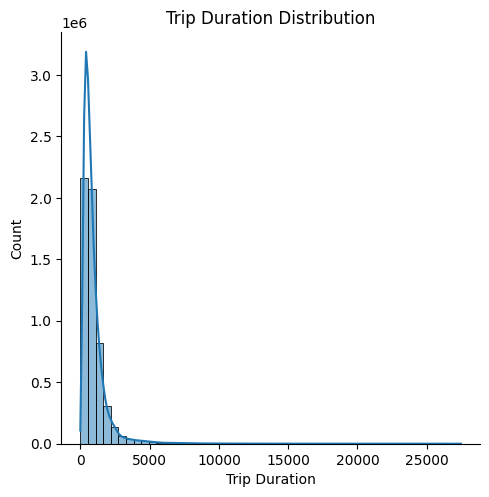

In [30]:
# visualize the distribution of the numeric variables

#plot trip duration
sns.displot(data=df, x='Trip Duration', kind='hist', kde='show', bins = 50)
plt.title('Trip Duration Distribution')

plt.show()

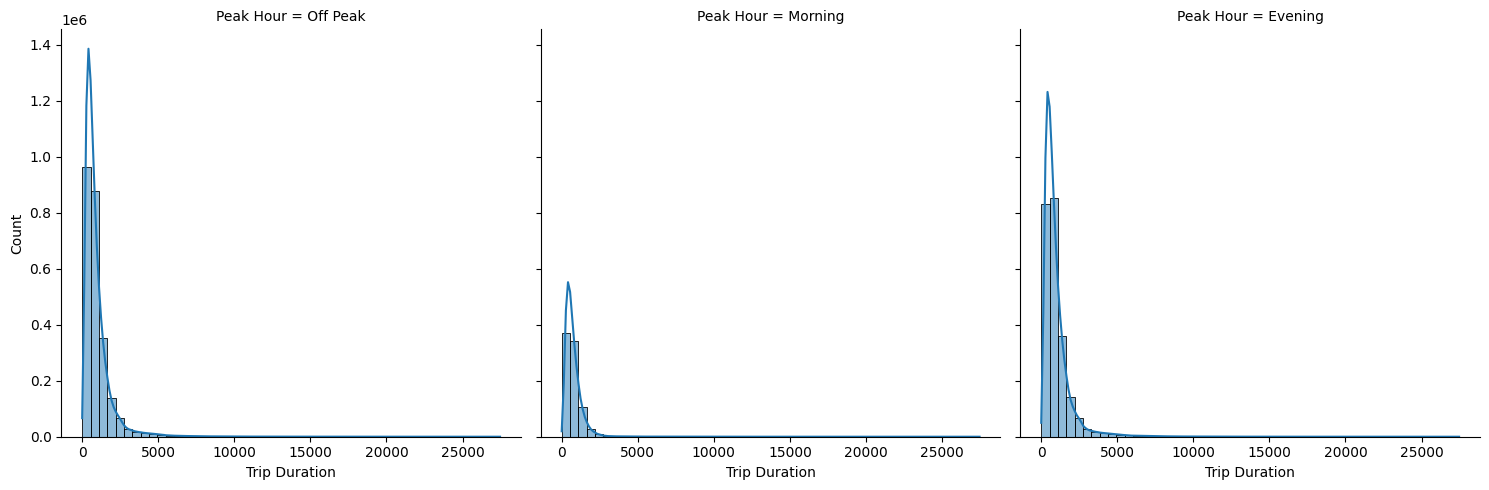

In [31]:
#plot 
sns.displot(data=df, x='Trip Duration', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

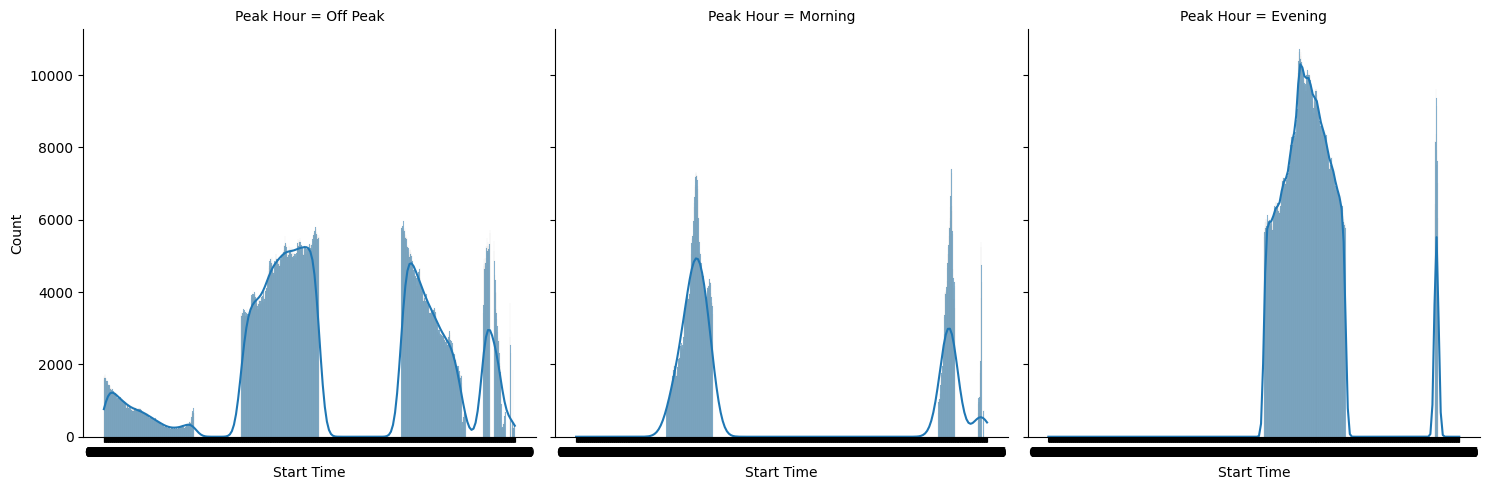

In [32]:
#plot 
sns.displot(data=df, x='Start Time', col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

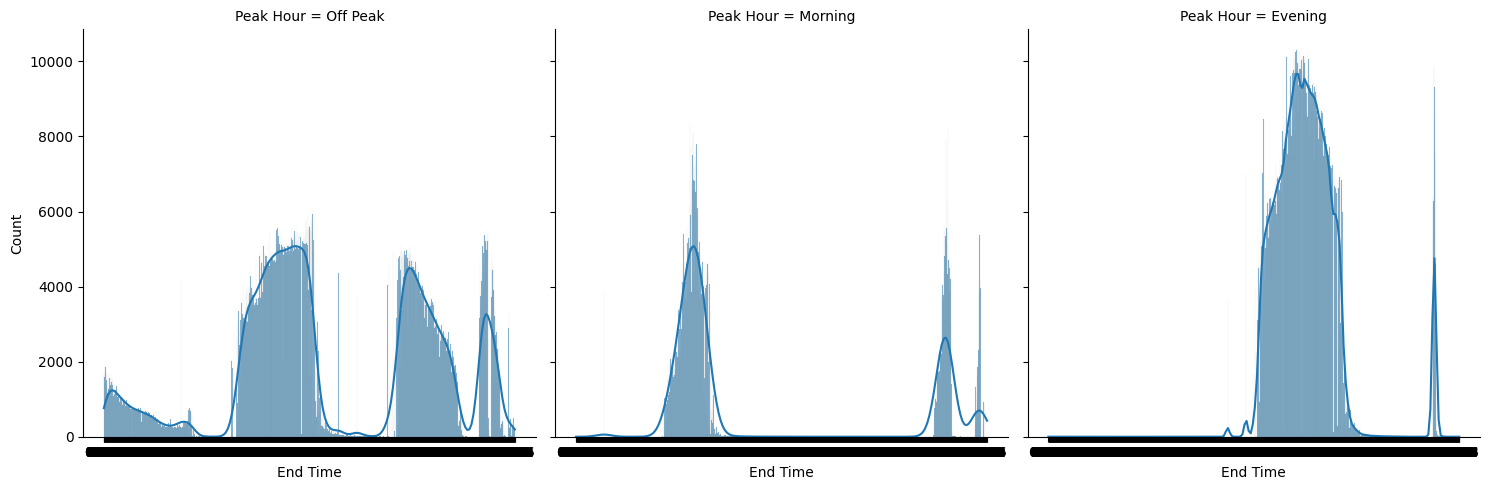

In [33]:
#plot 
sns.displot(data=df, x='End Time',col='Peak Hour', kind='hist', kde='show', bins = 50)

plt.show()

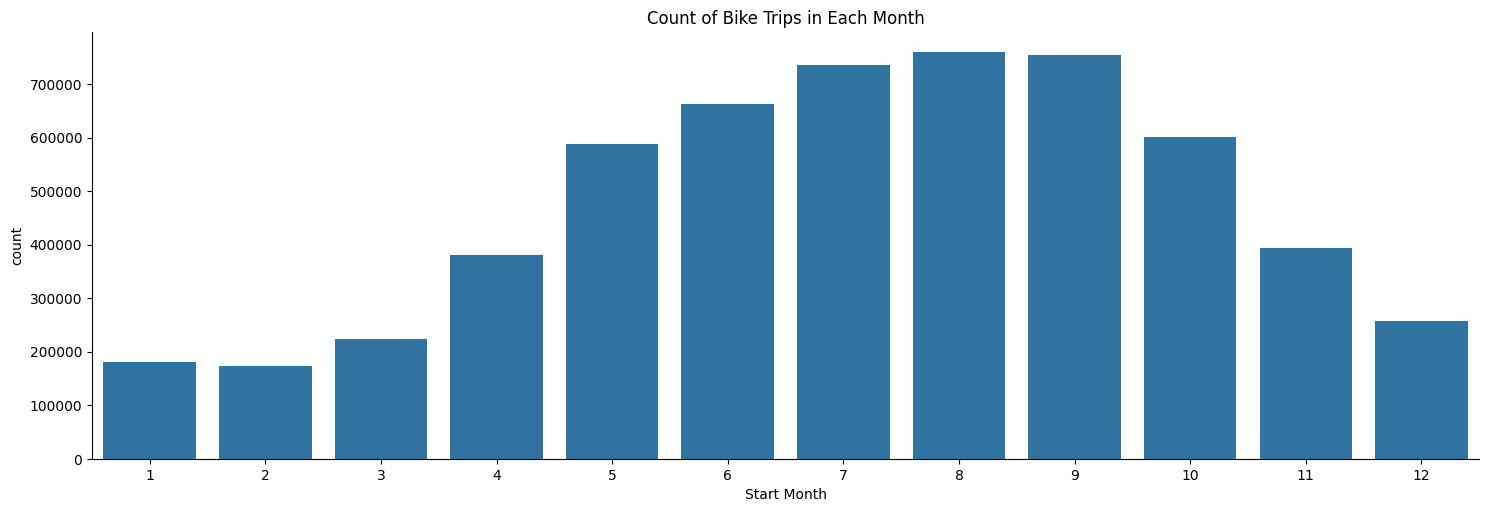

In [34]:
# plot categorical variable
sns.catplot(data=df, x='Start Month', kind='count', aspect = 3)
plt.title('Count of Bike Trips in Each Month')

plt.show()

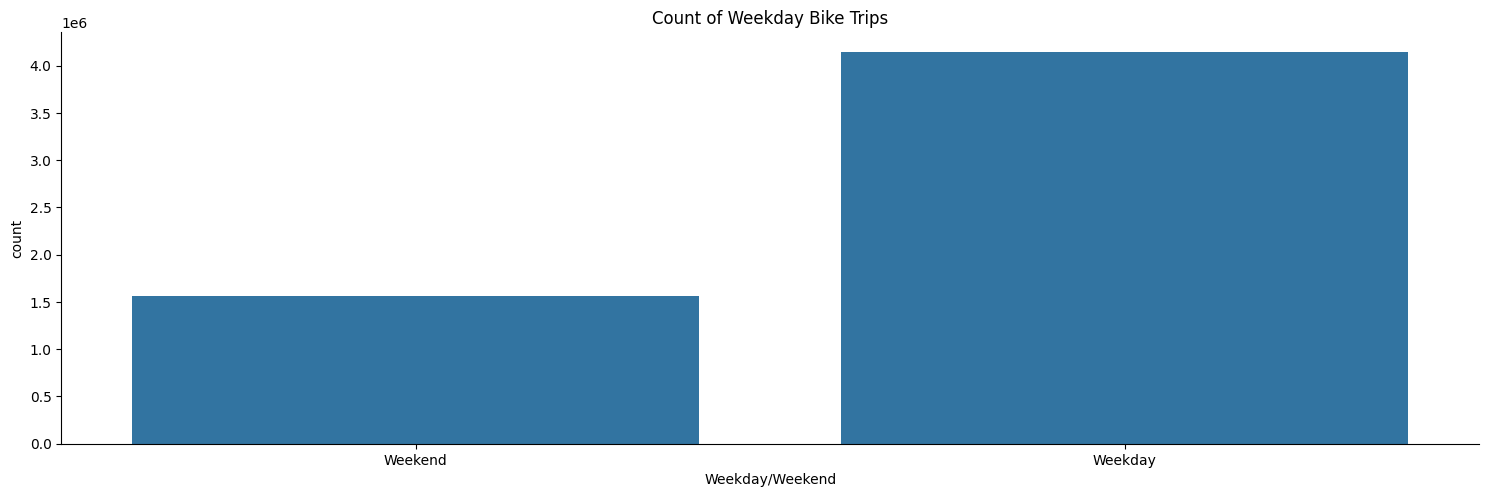

In [35]:
# plot categorical variable
sns.catplot(data=df, x='Weekday/Weekend', kind='count', aspect = 3)
plt.title('Count of Weekday Bike Trips')

plt.show()

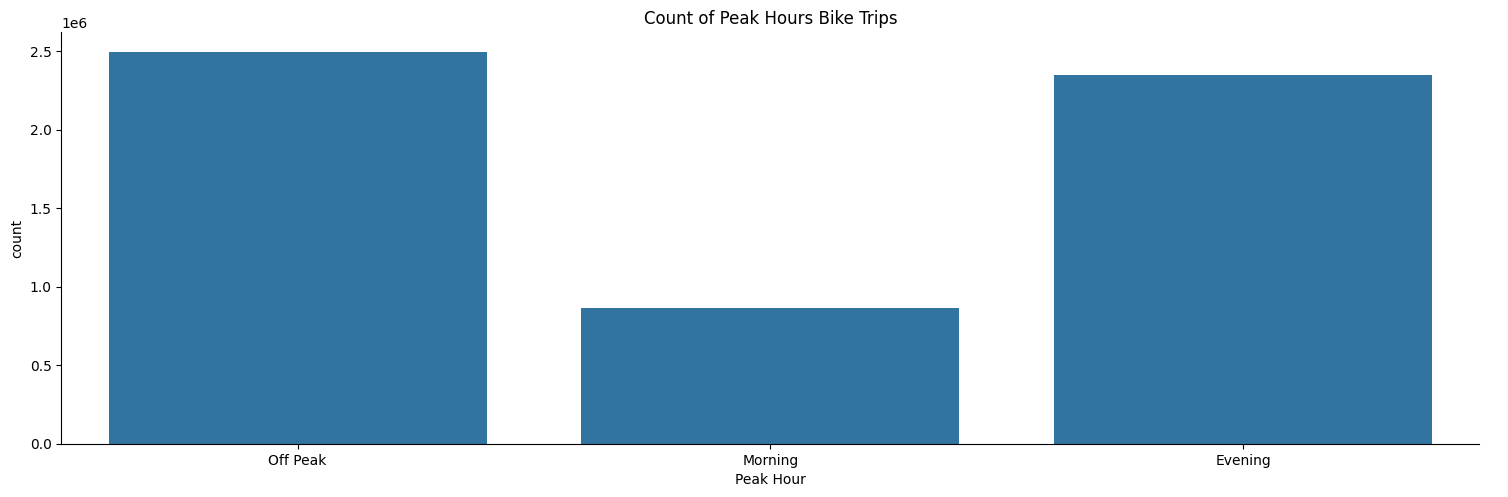

In [36]:
# plot categorical variable
sns.catplot(data=df, x='Peak Hour', kind='count', aspect = 3)
plt.title('Count of Peak Hours Bike Trips')

plt.show()

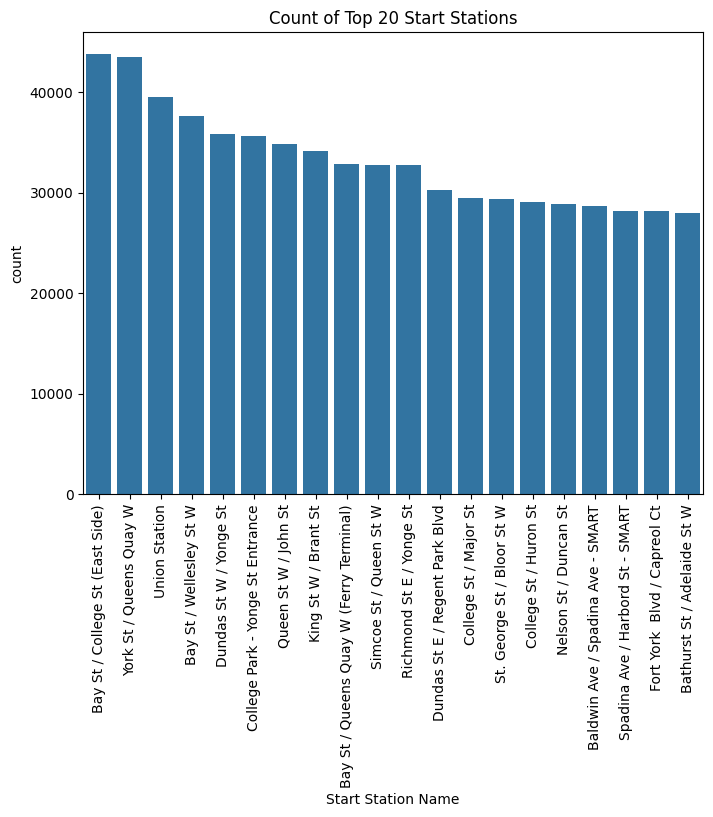

In [37]:
top_20_Stations = df['Start Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['Start Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='Start Station Name', order=top_20_Stations)
plt.title('Count of Top 20 Start Stations')
plt.xticks(rotation='vertical')
plt.show()


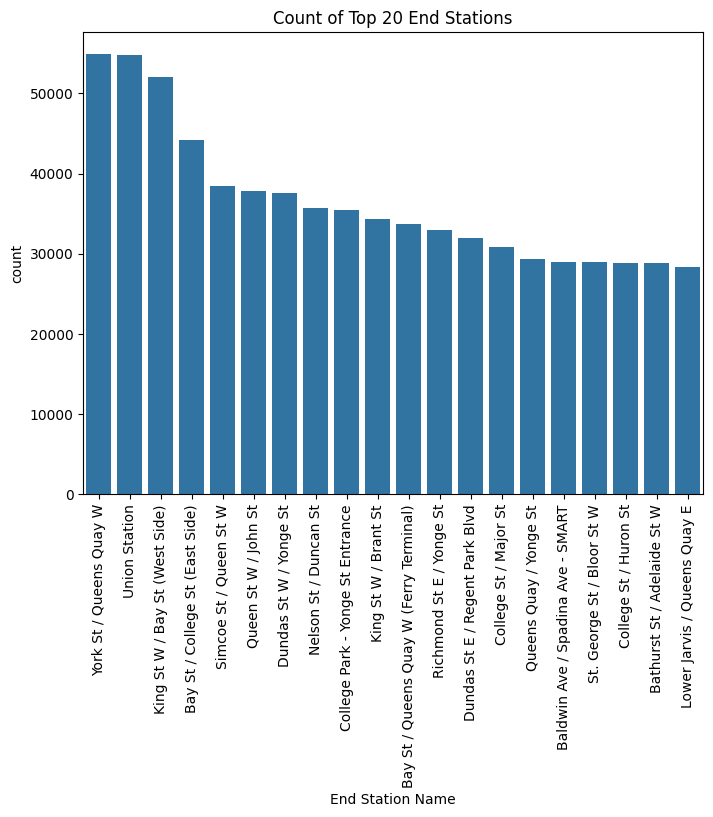

In [38]:
top_20_Stations = df['End Station Name'].value_counts().nlargest(20).index

# Filter the DataFrame to include only the top N categories
df_top_20 = df[df['End Station Name'].isin(top_20_Stations)]

# Create the countplot, ordering by frequency
plt.figure(figsize=(8, 6))
sns.countplot(data=df_top_20, x='End Station Name', order=top_20_Stations)
plt.title('Count of Top 20 End Stations')
plt.xticks(rotation='vertical')
plt.show()

In [17]:
df

,Trip Duration,Trip Duration (mm:ss),Start Station Id,Start Station Name,Start Time,Start Day,Start Month,Start Date,End Station Id,End Station Name,End Time,End Day,End Month,End Date,User Type,Weekday/Weekend,Peak Hour
0,840.0,14:00,7022,Simcoe St / Queen St W,00:00,1,1,2023-01-01,7703.0,NaN,00:14,1,1,2023-01-01,Casual Member,Weekend,Off Peak
1,722.0,12:02,7399,Lower Jarvis / Queens Quay E,00:01,1,1,2023-01-01,7533.0,Housey St / Dan Leckie Way,00:13,1,1,2023-01-01,Casual Member,Weekend,Off Peak
2,1054.0,17:34,7269,Toronto Eaton Centre (Yonge St),00:02,1,1,2023-01-01,7076.0,York St / Queens Quay W,00:20,1,1,2023-01-01,Annual Member,Weekend,Off Peak
3,1329.0,22:09,7721,NaN,00:04,1,1,2023-01-01,7685.0,NaN,00:26,1,1,2023-01-01,Casual Member,Weekend,Off Peak
4,1291.0,21:31,7721,NaN,00:04,1,1,2023-01-01,7685.0,NaN,00:26,1,1,2023-01-01,Casual Member,Weekend,Off Peak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707468,185.0,3:05,7391,Yonge St / Dundas Sq,23:56,31,12,2023-12-31,7041.0,Edward St / Yonge St,23:59,31,12,2023-12-31,Casual Member,Weekend,Off Peak
5707469,802.0,13:22,7366,Fort York Blvd / Bathurst St SMART,23:56,31,12,2023-12-31,7048.0,Front St W / Yonge St (Hockey Hall of Fame),00:10,1,1,2024-01-01,Casual Member,Weekend,Off Peak
5707470,1314.0,21:54,7203,Bathurst St/Queens Quay(Billy Bishop Airport),23:57,31,12,2023-12-31,7719.0,NaN,00:19,1,1,2024-01-01,Casual Member,Weekend,Off Peak
5707471,371.0,6:11,7788,NaN,23:58,31,12,2023-12-31,7788.0,NaN,00:05,1,1,2024-01-01,Casual Member,Weekend,Off Peak


In [18]:
df.index

RangeIndex(start=0, stop=5707473, step=1)

In [19]:
df_diagnostic = df

# Converting some variables into integer (would be used in the diagnostic analysis)
df_diagnostic['Start Day'] = df_diagnostic['Start Day'].astype(int)
df_diagnostic['Start Month'] = df_diagnostic['Start Month'].astype(int)
df_diagnostic['End Day'] = df_diagnostic['End Day'].astype(int)
df_diagnostic['End Month'] = df_diagnostic['End Month'].astype(int)

# Convert 'Start Hour' into a numeric value
df_diagnostic['Start Hour'] = pd.to_datetime(df_diagnostic['Start Time'], format = '%H:%M', errors = 'coerce').dt.hour

#df_diagnostic.set_index('Trip Id')
# Index disappeared? Setting a new one with just the count
# ('Trip Id' no longer exists after the conversion to a list and the new ordering)

df_diagnostic['Trip Number'] = range(1, len(df) + 1)
df_diagnostic = df_diagnostic.set_index('Trip Number')

In [ ]:
df_pears = df_diagnostic

df_pears.select_dtypes(int)
sns.pairplot(df_pears)
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x10d279d20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

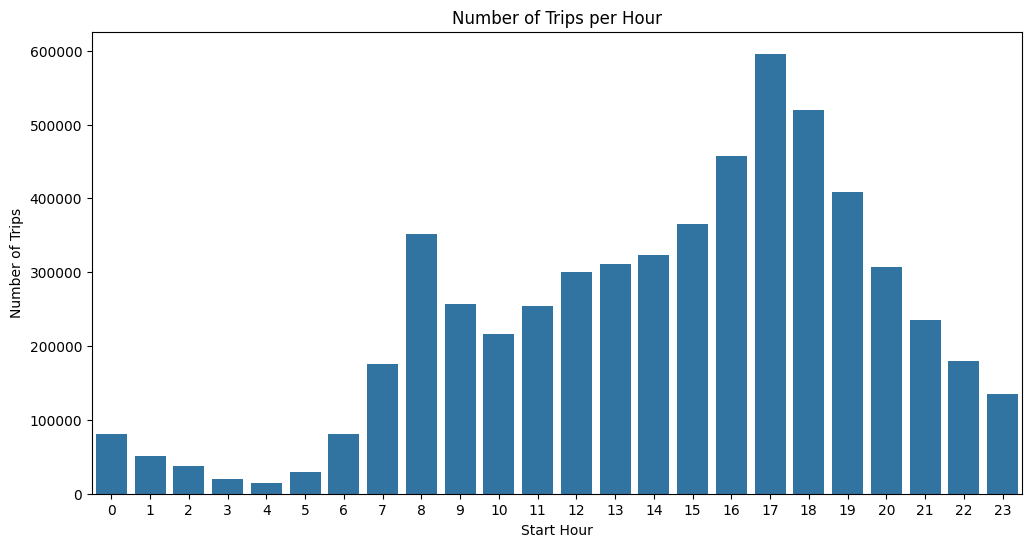

In [20]:
# Count the amount of rides per hour
hour_counts = df_diagnostic['Start Hour'].value_counts().sort_index()

# Create the bar plot and show the number of trips per hour
plt.figure(figsize=(12,6))
sns.barplot(x = hour_counts.index, y = hour_counts.values)
plt.title("Number of Trips per Hour")
plt.xlabel("Start Hour")
plt.ylabel("Number of Trips")
plt.show()

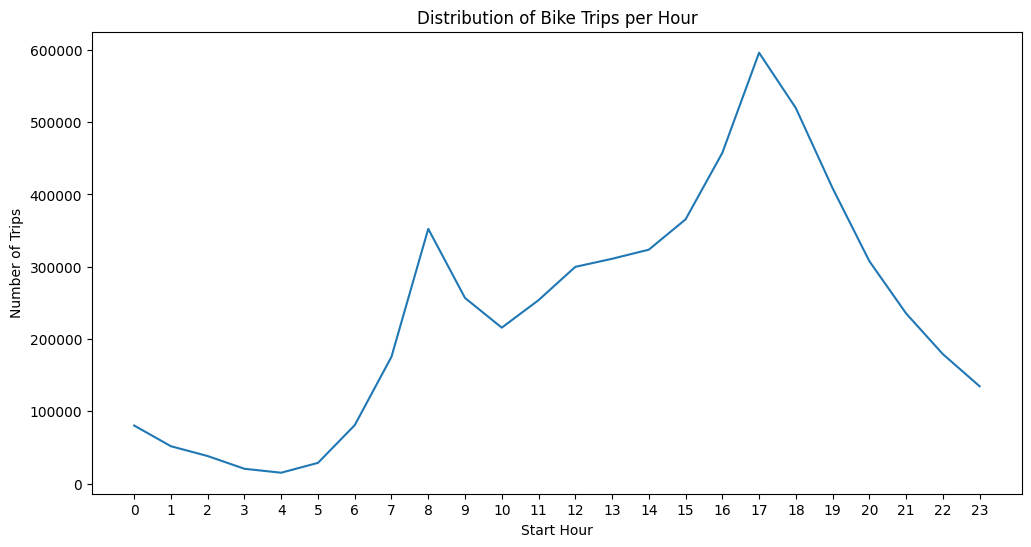

In [ ]:
# Create a line plot and show the evolution of trips during each hour
plt.figure(figsize = (12,6))
sns.lineplot(data = df_diagnostic, x = 'Start Hour', y = 'Trip Duration', estimator = 'count', errorbar = None)
plt.xticks(range(24))
plt.title('Distribution of Bike Trips per Hour')
plt.ylabel('Number of Trips')
plt.show()

In [21]:
df_hour_week = pd.crosstab(df_diagnostic['Start Hour'], df_diagnostic['Weekday/Weekend'])
#df_hour_week = pd.crosstab(df_diagnostic['Start Hour'], df_diagnostic['Weekday/Weekend'], normalize = 'index') * 100
df_hour_week.sort_values(by = 'Weekday', ascending = False).round(2)

Weekday/Weekend,Weekday,Weekend
Start Hour,,
17,471215,124713
18,402143,117242
16,331182,126248
8,318797,33556
19,307058,101538
15,241071,124372
20,229275,78415
9,202159,54633
14,201696,121856


In [ ]:
peak_hour_weekday = pd.crosstab(df['Peak Hour'], df['Weekday/Weekend'])
peak_hour_month = pd.crosstab(df['Peak Hour'], df['Start Month'])
peak_hour_weekday

Weekday/Weekend,Weekday,Weekend
Peak Hour,,
Evening,1752669,594113
Morning,746680,118812
Off Peak,1646985,848214


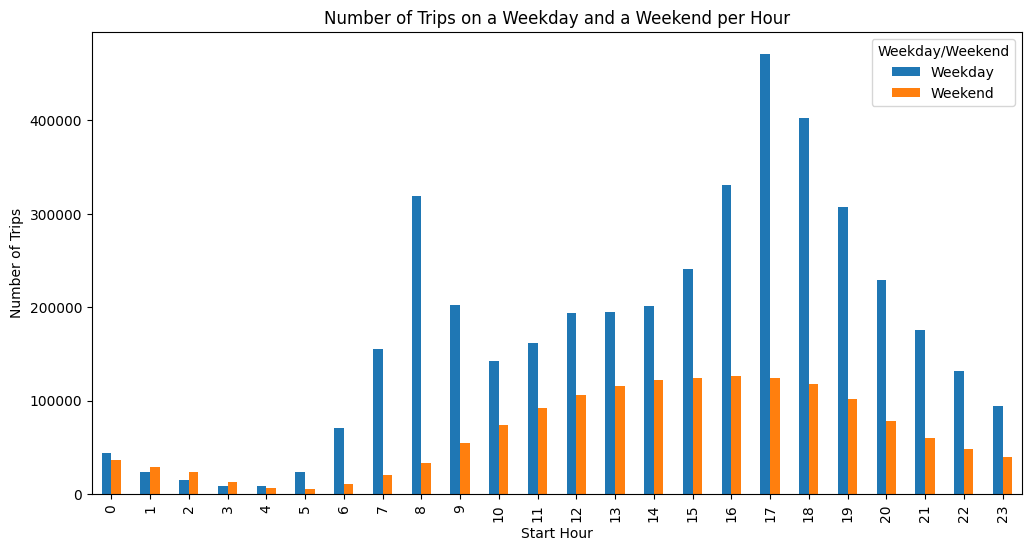

In [ ]:
df_hour_week.plot(kind = 'bar', figsize=(12,6))
plt.title('Number of Trips on a Weekday and a Weekend per Hour')
plt.xticks(range(24))
plt.xlabel('Start Hour')
plt.ylabel('Number of Trips')
plt.show()

In [ ]:
df_user_peak = pd.crosstab(df_diagnostic['User Type'], df_diagnostic['Start Hour'])
df_user_peak.transpose()

User Type,Annual Member,Casual Member
Start Hour,,
0,4214,76163
1,2777,48958
2,1797,36369
3,1199,19349
4,1110,13999
5,2627,26117
6,6501,74340
7,14717,160789
8,27741,324612


In [22]:
# Turn 'Peak Hour' into binary values
df_diagnostic['Peak Hour (Binary)'] = df_diagnostic['Peak Hour'].map({'Off Peak': 0, 'Morning': 1, 'Evening': 1})
df_diagnostic['Weekday/Weekend (Binary)'] = df_diagnostic['Weekday/Weekend'].map({'Weekend': 0, 'Weekday': 1})

In [ ]:
# Calculated the correlation score for select variables using .corr()
df_correlation = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour (Binary)', 'Weekday/Weekend (Binary)']]
df_correlation.corr()

,Trip Duration,Start Hour,Peak Hour (Binary),Weekday/Weekend (Binary)
Trip Duration,1.000000,0.045968,-0.015763,-0.095688
Start Hour,0.045968,1.000000,0.030458,0.029156
Peak Hour (Binary),-0.015763,0.030458,1.000000,0.131308
Weekday/Weekend (Binary),-0.095688,0.029156,0.131308,1.000000


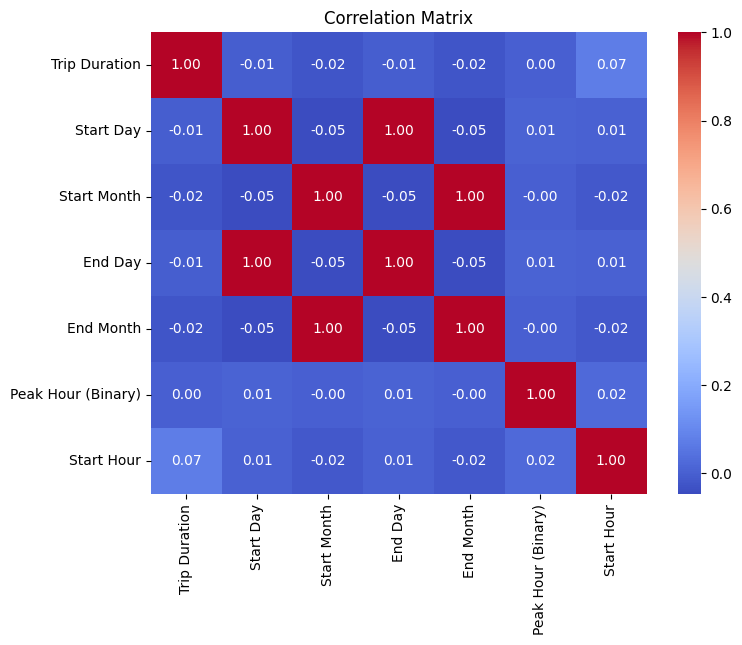

In [23]:
# Correlation analysis with a matrix
# Select relevant variables
numeric = ['Trip Duration', 'Start Day', 'Start Month', 'End Day', 'End Month', 'Peak Hour (Binary)', 'Start Hour']
df_diagnostic['Trip Duration'] = df_diagnostic['Trip Duration'] / 60  # Convert to minutes
df_diagnostic = df_diagnostic[df_diagnostic['Trip Duration'] < 45] # Remove outliers 

# Calculating the correlation scores of the selected variables and assigning them to a data frame
correlation_matrix = df_diagnostic[numeric].corr()
correlation_matrix

# Plotting the Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [24]:
df_diagnostic['Trip Duration'].sort_values(ascending = False)

Trip Number
2226915    44.983333
1515075    44.983333
1853882    44.983333
1353035    44.983333
2490856    44.983333
             ...    
5576557     0.000000
2402767     0.000000
1985980     0.000000
75843       0.000000
3534944     0.000000
Name: Trip Duration, Length: 5491530, dtype: float64

In [25]:
# Select relevant variables and drop missing values
df_regression = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type']].dropna()
df_regression['Trip Duration'] = df_regression['Trip Duration'] / 60  # Convert to minutes
df_regression = df_regression[df_regression['Trip Duration'] < 45] # Remove outliers 

# Convert Trip Duration to numeric (forces errors to NaN, then drop them)
df_regression['Trip Duration'] = pd.to_numeric(df_regression['Trip Duration'], errors='coerce')

# Convert categorical variables into a binary format (One-hot Encoding)
df_regression = pd.get_dummies(df_regression, columns=['Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type'], drop_first=True)

# Split X and y
X = df_regression.drop(columns=['Trip Duration'])
y = df_regression['Trip Duration']

# Force all X columns to float
X = X.astype(float)
y = y.astype(float)

# Add intercept for OLS
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()

# Show summary
print(results.summary())

# Log transformation and remove outliers
# Specify which variables to pick for regression modeling: for Trip Duration and Peak Hour or Weekday (Can we predict if it is a weekday/commute based on trip duration? Any relationships?)
# Run NB: Quite a bit of cathegorical data that we can ask prediction for.
# PCA

                            OLS Regression Results                            
Dep. Variable:          Trip Duration   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3726.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        02:54:12   Log-Likelihood:             2.8904e+06
No. Observations:             5491530   AIC:                        -5.781e+06
Df Residuals:                 5491502   BIC:                        -5.780e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    9

In [ ]:
#multiple models, each dummy is 1 DV

# Select relevant variables and drop missing values
df_regression = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type']].dropna()
df_regression['Trip Duration'] = df_regression['Trip Duration'] / 60  # Convert to minutes
df_regression = df_regression[df_regression['Trip Duration'] < 45] # Remove outliers 

#above code removing outliers does not make a diff in the output 

# Convert Trip Duration to numeric (forces errors to NaN, then drop them)
df_regression['Trip Duration'] = pd.to_numeric(df_regression['Trip Duration'], errors='coerce')

#change months to dummy
dummy_months = pd.get_dummies(df['Start Month'], prefix='Month', drop_first=True)
df_regression = pd.concat([df, dummy_months], axis=1)

#find dummy columns
dummy_cols = dummy_months.columns

#convert dummy columns from bool to int
df_regression[dummy_cols] = df_regression[dummy_cols].astype(int)

#IV
X = df_regression[['Trip Duration']]
X = sm.add_constant(X)

#DV loop, 1 model per month
for col in dummy_cols:
    Y = df_regression[col]
    model = sm.OLS(Y, X).fit()
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                Month_2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3020.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        04:00:43   Log-Likelihood:             1.9736e+06
No. Observations:             5707473   AIC:                        -3.947e+06
Df Residuals:                 5707471   BIC:                        -3.947e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0336   9.46e-05    355.777

In [ ]:
#TRIP DURATION AS DV
# Select relevant variables and drop missing values
df_regression = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour','Weekday/Weekend', 'User Type']].dropna()
df_regression['Trip Duration'] = df_regression['Trip Duration'] / 60  # Convert to minutes
df_regression = df_regression[df_regression['Trip Duration'] < 45] # Remove outliers 

#above code removing outliers does not make a diff in the output 

# Convert Trip Duration to numeric (forces errors to NaN, then drop them)
df_regression['Trip Duration'] = pd.to_numeric(df_regression['Trip Duration'], errors='coerce')
#change months to dummy
dummy_months = pd.get_dummies(df['Start Month'], prefix='Month', drop_first=True)
df_regression = pd.concat([df, dummy_months], axis=1)

#find dummy columns
dummy_cols = dummy_months.columns

#convert dummy columns from bool to int
df_regression[dummy_cols] = df_regression[dummy_cols].astype(int)

#DVs and IVs
Y = df_regression['Trip Duration']
X = df_regression[dummy_cols]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Trip Duration   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4536.
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        04:01:26   Log-Likelihood:            -4.8070e+07
No. Observations:             5707473   AIC:                         9.614e+07
Df Residuals:                 5707461   BIC:                         9.614e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        767.9970      2.593    296.173      0.0

In [ ]:
# naive bayes analysis

#remove all nulls

df_ml = df_diagnostic[['Trip Duration', 'Start Hour', 'Peak Hour (Binary)','Weekday/Weekend']].dropna()
df_ml['Trip Duration'] = df_ml['Trip Duration'] / 60  # Convert to minutes


# reset categorical variables
le=LabelEncoder()

for col in df_ml.columns:
    if df_ml[col].dtype == 'object':
        df_ml[col] = le.fit_transform(df_ml[col])
        

# create new variables for machine learning
x = df_ml.drop('Peak Hour (Binary)', axis=1) # features
y = df_ml['Peak Hour (Binary)'] # target

# split the data

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# select the model
model = MultinomialNB()

# train the model

model.fit(x_train, y_train)

# make predicitons
y_pred = model.predict(x_test)

In [ ]:
# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5814953197342082

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.25      0.34    499027
           1       0.59      0.84      0.69    642468

    accuracy                           0.58   1141495
   macro avg       0.57      0.54      0.52   1141495
weighted avg       0.57      0.58      0.54   1141495


Confusion Matrix:
 [[124275 374752]
 [102969 539499]]


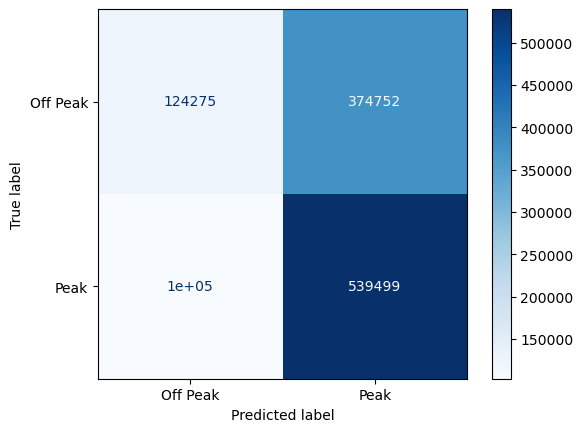

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# display

labels = ["Off Peak", "Peak"]  # set the labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap = 'Blues')

In [ ]:
#end of naive bayes work